# My submission to the ArangoDb Hackathon
## By Patrick Wendo

The dataset used in this notebook is available on Kaggle [here](https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist)

In [1]:
!pip3 install kagglehub pandas numpy networkx matplotlib nx_arangodb scipy

Defaulting to user installation because normal site-packages is not writeable


In [29]:
from arango import ArangoClient

import networkx as nx
import nx_arangodb as nxadb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import ast
import re

anime = pd.read_csv(
    "./datasets/myanimelist/anime.csv"
)

manga = pd.read_csv(
    "./datasets/myanimelist/manga.csv"
)

anime.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          24985 non-null  int64  
 1   title             24985 non-null  object 
 2   type              24927 non-null  object 
 3   score             16050 non-null  float64
 4   scored_by         24985 non-null  int64  
 5   status            24985 non-null  object 
 6   episodes          24438 non-null  float64
 7   start_date        24110 non-null  object 
 8   end_date          22215 non-null  object 
 9   source            21424 non-null  object 
 10  members           24985 non-null  int64  
 11  favorites         24985 non-null  int64  
 12  episode_duration  24387 non-null  object 
 13  total_duration    24162 non-null  object 
 14  rating            24405 non-null  object 
 15  sfw               24985 non-null  bool   
 16  approved          24985 non-null  bool  

In [30]:
manga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64833 entries, 0 to 64832
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manga_id           64833 non-null  int64  
 1   title              64833 non-null  object 
 2   type               64833 non-null  object 
 3   score              24636 non-null  float64
 4   scored_by          64833 non-null  int64  
 5   status             64833 non-null  object 
 6   volumes            48211 non-null  float64
 7   chapters           46042 non-null  float64
 8   start_date         62950 non-null  object 
 9   end_date           51932 non-null  object 
 10  members            64833 non-null  int64  
 11  favorites          64833 non-null  int64  
 12  sfw                64833 non-null  bool   
 13  approved           64833 non-null  bool   
 14  created_at_before  64833 non-null  object 
 15  updated_at         62678 non-null  object 
 16  real_start_date    629

### Data Exploration

- We have 2 datasets, anime and manga. 
- These are both relational datasets with a single entry having multiple values. We need to figure out how to represent this data as a graph. 

#### Our Strategy.
- We could represent this as an attributed graph with node attributes and edge attributes. An **attributed graph** is one where aside from node labels, or edge labels, a node or an edge will also have additional metadata. For example, in a graph about people, we could have a node with the label "Anna" with attributes `{position: "CEO", start_date: "2019-08-19"}`. 

- The node label would be the name of the anime/manga. We could also have some columns be extracted to nodes of their own. For instance, an anime could fall into multiple genres. We could have each of those as a separate node. Similarly for columns like studios, themes, producers, licensors and demographics.

In [3]:
# Exploration of the anime dataset
pd.set_option("display.max.columns", None)
[anime.shape, manga.shape]

[(24985, 39), (64833, 30)]

- The anime dataset has about **24,985 rows with 39 columns**, while the manga dataset has **64,833 rows and 30 columns**

In [32]:
anime.columns

Index(['anime_id', 'title', 'type', 'score', 'scored_by', 'status', 'episodes',
       'start_date', 'end_date', 'source', 'members', 'favorites',
       'episode_duration', 'total_duration', 'rating', 'sfw', 'approved',
       'created_at', 'updated_at', 'start_year', 'start_season',
       'real_start_date', 'real_end_date', 'broadcast_day', 'broadcast_time',
       'genres', 'themes', 'demographics', 'studios', 'producers', 'licensors',
       'synopsis', 'background', 'main_picture', 'url', 'trailer_url',
       'title_english', 'title_japanese', 'title_synonyms'],
      dtype='object')

In [33]:
manga.columns

Index(['manga_id', 'title', 'type', 'score', 'scored_by', 'status', 'volumes',
       'chapters', 'start_date', 'end_date', 'members', 'favorites', 'sfw',
       'approved', 'created_at_before', 'updated_at', 'real_start_date',
       'real_end_date', 'genres', 'themes', 'demographics', 'authors',
       'serializations', 'synopsis', 'background', 'main_picture', 'url',
       'title_english', 'title_japanese', 'title_synonyms'],
      dtype='object')

##### Data Fix #1
- Fix string that look like lists, `"[list, item]" -> ["list", "item"]`. This will allow us to use the #explode() function later when creating data in NetworkX

In [6]:
anime_columns_to_fix = ["genres", "themes", "demographics", "title_synonyms", "studios"]
manga_columns_to_fix = ["genres", "themes", "demographics", "authors"]

def rewrite_anime(col):
    anime[col] = anime[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def rewrite_manga(col):
    manga[col] = manga[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

for col in anime_columns_to_fix:
    rewrite_anime(col)

for col in manga_columns_to_fix:
    rewrite_manga(col)

##### Data Fix #2
- because the anime, manga, genres, themes, etc etc will use an ID of some kind, we update the anime ID to be prefixed with `a_<id>`

In [27]:
def update_anime_id(anime_df):
    anime_df["anime_id"] = anime_df["anime_id"].astype(str).apply(lambda x: f"a_{x}")
    return anime_df  # Ensure the function returns the updated DataFrame


anime = update_anime_id(anime)
anime.head(1)["anime_id"]

0    a_a_5114
Name: anime_id, dtype: object

In [34]:
## Identify Key groups in the following columns: "genres", "themes", "demographics", "studios". These could be shared between anime entries.

genre_explode = anime.explode('genres')
genre_grouped_data = genre_explode.groupby("genres")
anime_genres = genre_grouped_data.groups.keys()

theme_explode = anime.explode('themes')
theme_grouped_data = theme_explode.groupby("themes")
anime_themes = theme_grouped_data.groups.keys()

demographics_explode = anime.explode('demographics')
demographic_grouped_data = demographics_explode.groupby("demographics")
anime_demographics = demographic_grouped_data.groups.keys()

studios_explode = anime.explode('studios')
studio_grouped_data = studios_explode.groupby("studios")
anime_studios = studio_grouped_data.groups.keys()


##### Dealing with the authors column in the manga dataset.
- The author field in Manga datasets should be extracted into it's own dataset. Each author will be a node on it's own. They may be shared across datasets. The node label will be the id with attributes being first name, last name and role. 

In [9]:
manga_authors = manga["authors"]
manga_authors.explode().head()[0]

0    {'id': 1868, 'first_name': 'Kentarou', 'last_n...
0    {'id': 49592, 'first_name': '', 'last_name': '...
Name: authors, dtype: object

##### Creating new DataFrames for NetworkX compatibility

- The node data needs to be in a form like 
```
    {
        node: <node-name>,
        attribute_1: <attribute_1>,
        attribute_2: <attribute_2>,
        attribute_3: <attribute_3>,

    }
```

- Further, we need to define edge data. This would be an edge list of the form:
```
    {
        source: <source>,
        target: <target>,
        attribute_1: <attribute_1>,
        attribute_2: <attribute_2>,
        attribute_3: <attribute_3>,
    }
```

In [ ]:
# Building dataframe for "genres", "themes", "demographics", "studios" to be used in building nodes. 

demographics_df = pd.DataFrame(anime_demographics, columns=['demographics']).reset_index()
genres_df = pd.DataFrame(anime_genres, columns=['genres']).reset_index()
themes_df = pd.DataFrame(anime_themes, columns=["themes"]).reset_index()
studios_df = pd.DataFrame(anime_studios, columns=['studios']).reset_index()

list_of_dfs = [demographics_df, genres_df, themes_df, studios_df]

def update_indices(list_dfs):
    current_idx = 0
    for i in range(len(list_dfs)):  
        list_dfs[i] = list_dfs[i].reset_index(drop=True) 
        list_dfs[i]['index'] = range(current_idx, current_idx + len(list_dfs[i])) 
        list_dfs[i].index = range(current_idx, current_idx + len(list_dfs[i]))
        current_idx += len(list_dfs[i])

    return list_dfs  # Optional: return updated list


[demographics_df_idx, genres_df_idx, themes_df_idx, studios_df_idx] = update_indices(list_of_dfs)

##### Making the dataframe that can be loaded into networkX

The dataframes `demographics_df_idx, genres_df_idx, themes_df_idx, studios_df_idx` all have unique indices. These will be used in defining an edge list for the anime dataset. For now we work on creating the node list for the anime. 



In [11]:
# anime node attributes
node_label = "anime_id"
node_attributes = {
    "id": "anime_id",
    "name": "title",
    "type": "type", 
    "score": "score", 
    "status": "status",
    "start_date": "real_start_date", 
    "end_date": "real_end_date", 
    "source": "source", 
    "episode_duration": "episode_duration", 
    "total_duration": "total_duration",
    "sfw": "sfw", 
    "start_year": "start_year", 
    "start_season": "start_season", 
    "broadcast_day": "broadcast_day",
    "main_picture": "main_picture",
    "url": "url",
    "trailer_url": "trailer_url",
    "title_english": "title_english",
    "title_japanese": "title_japanese",
    "title_synonyms": "title_synonyms" 
}

(node_attributes.values())
attributed_anime = anime[anime.columns.intersection(list(node_attributes.values()))]


In [12]:
## Building the edge list. 

def build_edge_list(dataframe1, dataframe2, merge_field):
    exploded_df = dataframe1.explode(merge_field)
    edge_list_df = exploded_df.merge(dataframe2, left_on=merge_field, right_on=merge_field)
    edge_list_df = edge_list_df[['anime_id', 'index']]
    return edge_list_df

demographics_edge_list = build_edge_list(anime, demographics_df_idx, "demographics")
genres_edge_list = build_edge_list(anime, genres_df_idx, "genres")
themes_edge_list = build_edge_list(anime, themes_df_idx, "themes")
studios_edge_list = build_edge_list(anime, studios_df_idx, "studios")


#### NetworkX

- Playing around with NetworkX

In [13]:

# Adding nodes for "genres", "themes", "demographics", "studios"
G = nx.Graph()

demographic_attributes = demographics_df_idx.set_index('index').to_dict(orient='index')
genres_attributes = genres_df_idx.set_index('index').to_dict(orient='index')
themes_attributes = themes_df_idx.set_index('index').to_dict(orient='index')
studios_attributes = studios_df_idx.set_index('index').to_dict(orient='index')
G.add_nodes_from(demographic_attributes.items())
G.add_nodes_from(genres_attributes.items())
G.add_nodes_from(themes_attributes.items())
G.add_nodes_from(studios_attributes.items())
G.add_nodes_from(attributed_anime.set_index('anime_id').to_dict(orient='index').items())
theme_edges = list(themes_edge_list.itertuples(index=False, name=None))
genres_edges = list(genres_edge_list.itertuples(index=False, name=None))
demographics_edges = list(demographics_edge_list.itertuples(index=False, name=None))
studios_edges = list(studios_edge_list.itertuples(index=False, name=None))
G.add_edges_from(theme_edges)
G.add_edges_from(genres_edges)
G.add_edges_from(demographics_edges)
G.add_edges_from(studios_edges)
G.size()
# print(studios_attributes.items())


83360

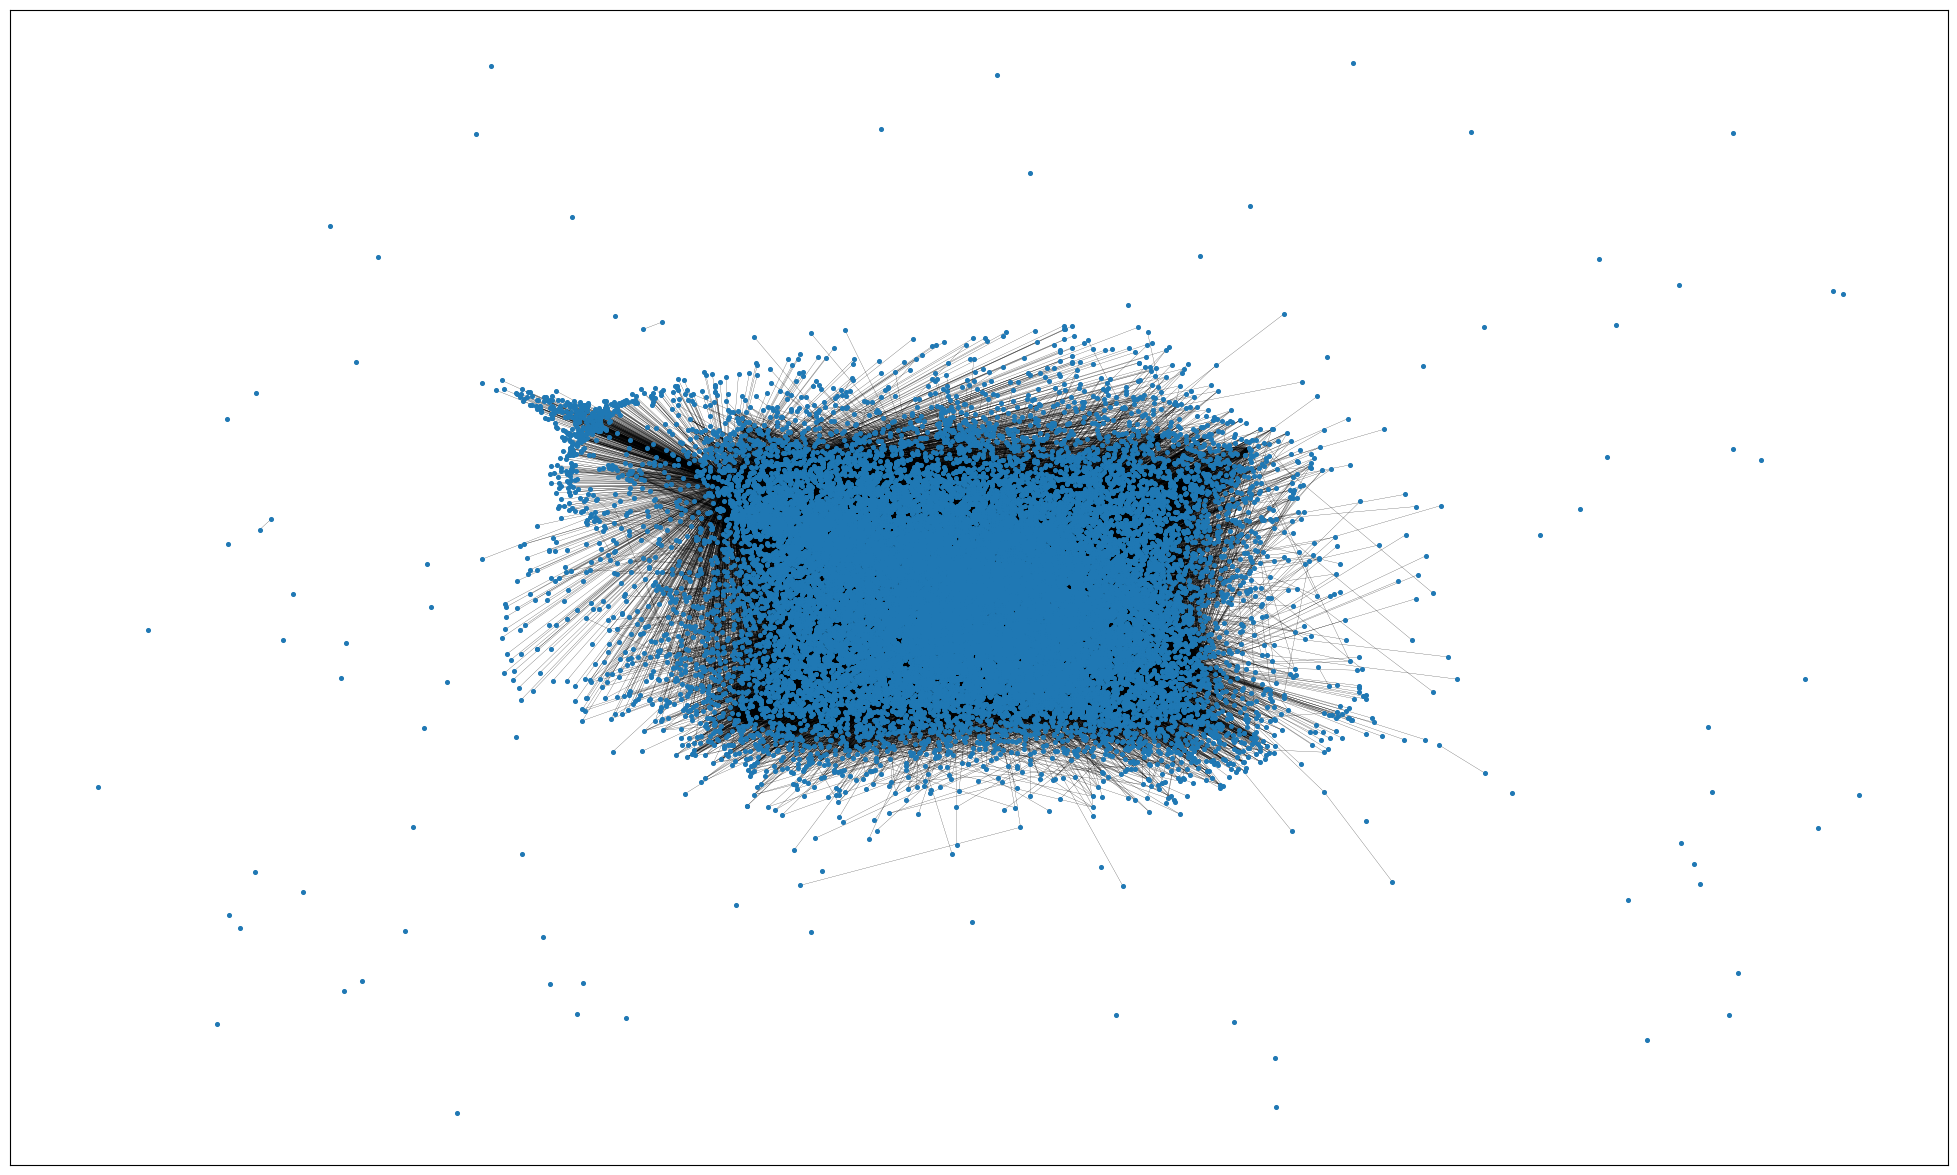

In [26]:
plot_options = {"node_size": 7, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=5, seed=1019)
fig, ax = plt.subplots(figsize=(25, 15))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)